In [1]:
# Pytorch Implementation of LeNet, from https://medium.datadriveninvestor.com/architecture-implementation-of-lenet-from-scratch-in-pytorch-709cc38c00a9

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time, copy


In [2]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84, 10)
    self.tanh = nn.Tanh()
    self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv3(x)
    x = self.tanh(x)
    
    x = x.reshape(x.shape[0], -1)
    x = self.linear1(x)
    x = self.tanh(x)
    x = self.linear2(x)
    return x

model = LeNet()
x = torch.randn(64,1,32,32)
output = model(x)

num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print('The number of parameters in the model is', num_params)

print(model)
#summary(model, (1,32,32))
print("output.shape : ",output.shape)


The number of parameters in the model is 61706
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
  (tanh): Tanh()
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
output.shape :  torch.Size([64, 10])


In [3]:
# Load the dataset

# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-3
num_epochs = 20

train_dataset = datasets.FashionMNIST(root='dataset/', train=True, 
                               transform=transforms.Compose([transforms.Pad(2), transforms.ToTensor()]), download=True)
test_dataset = datasets.FashionMNIST(root='dataset/', train=False, 
                              transform=transforms.Compose([transforms.Pad(2), transforms.ToTensor()]), download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
dataset_sizes = {'train':len(train_dataset), 'test':len(test_dataset)}

model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device

device(type='cpu')

In [4]:
# Does one epoch of training. Assumes the model is in training mode

def train_epoch(dataloader, model, criterion, optimizer, verbose=True):
    
    size = len(dataloader.dataset)

    for batchnum, (X, y) in enumerate(dataloader):
        # Compute prediction and loss on the minibatch
        yhat = model(X) # this calls forward on the minibatch (do not call forward directly)
        loss = criterion(yhat, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchnum % 100 == 0 and verbose:
            # report the loss on current minibatch every 100 minibatches
            loss, current = loss.item(), batchnum * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Computes loss and accuracy on the validation set. Assumes the model is in eval mode

def validate(dataloader, model, criterion, verbose=True):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # we don't want to accumulate the gradients during validation
        for X, y in dataloader:
            yhat = model(X)
            test_loss += criterion(yhat, y).item()
            correct += (yhat.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss
    

In [5]:
# Train

val_accs = np.array([0.0]*num_epochs)
val_losses = copy.deepcopy(val_accs)
train_accs = copy.deepcopy(val_accs)
train_losses = copy.deepcopy(val_accs)
all_time = 0 # records time spent training and evaluating model
lowest_error = np.inf
best_epoch = 0

for t in range(num_epochs):
    print(f"Epoch {t+1}/{num_epochs}\n-------------------------------")

    curtime = time.time()
    
    model.train() # turn model to train mode (for dropout, etc)
    train_epoch(train_loader, model, criterion, optimizer, verbose=True)
    
    model.eval() # turn model to evaluation mode (for dropout, etc)
    train_accs[t], train_losses[t] = validate(train_loader, model, criterion, verbose=False)
    val_accs[t], val_losses[t] = validate(test_loader, model, criterion, verbose=True)
    
    epoch_time = time.time() - curtime
    all_time += epoch_time

    # Store the parameters of the best performing model
    # Note: we use the losses to determine "best" model; 
    # this is not a defininitive choice of metric, e.g. you could use accuracy
    # Note: we could also store the state_dict for the optimizer, and
    # resume optimization from the best model
    if val_losses[t] < lowest_error:
        print("This is currently the best performing model, saving it")
        lowest_error = val_losses[t]
        best_epoch = t
        torch.save(model.state_dict(), 'best_lenet5_weights.pth')
    
    print(f"Epoch took {epoch_time:>0.1f} seconds (training + evaluation) \n")
    
print(f"Done training! Took {all_time:>0.1f} seconds")

Epoch 1/20
-------------------------------
loss: 2.304578  [    0/60000]
loss: 0.632782  [ 6400/60000]
loss: 0.771771  [12800/60000]
loss: 0.654551  [19200/60000]
loss: 0.481297  [25600/60000]
loss: 0.400611  [32000/60000]
loss: 0.426764  [38400/60000]
loss: 0.396358  [44800/60000]
loss: 0.416394  [51200/60000]
loss: 0.527878  [57600/60000]
Validation Error: 
 Accuracy: 82.3%, Avg loss: 0.484924
This is currently the best performing model, saving it
Epoch took 17.1 seconds (training + evaluation) 

Epoch 2/20
-------------------------------
loss: 0.499902  [    0/60000]
loss: 0.500046  [ 6400/60000]
loss: 0.551433  [12800/60000]
loss: 0.465937  [19200/60000]
loss: 0.704100  [25600/60000]
loss: 0.310114  [32000/60000]
loss: 0.315734  [38400/60000]
loss: 0.362817  [44800/60000]
loss: 0.339193  [51200/60000]
loss: 0.406987  [57600/60000]
Validation Error: 
 Accuracy: 85.5%, Avg loss: 0.402419
This is currently the best performing model, saving it
Epoch took 16.8 seconds (training + evalua

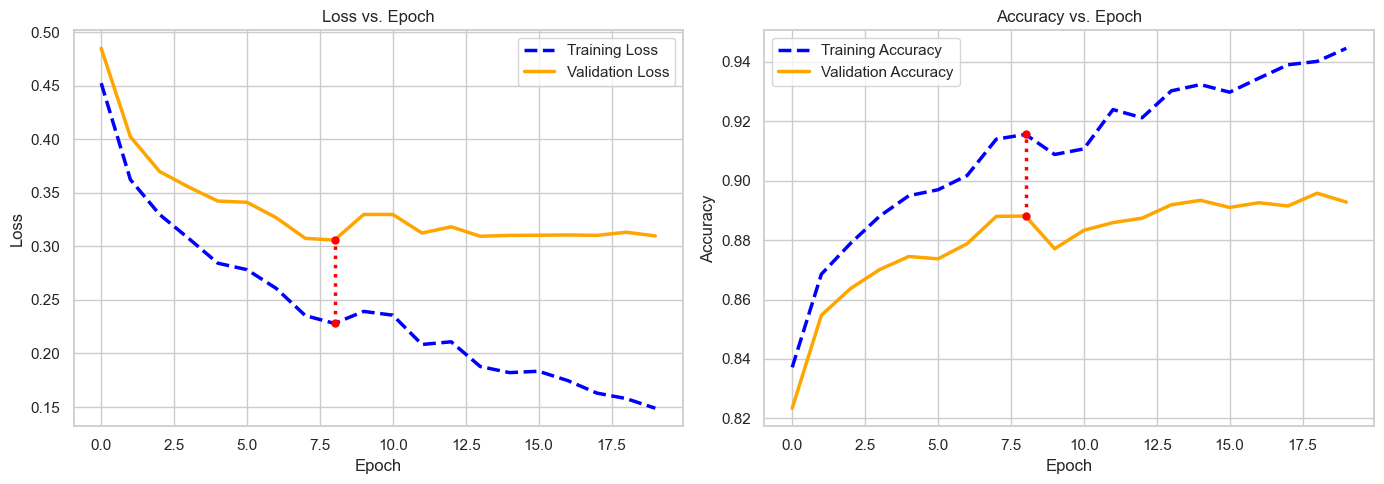

In [6]:
# Visualize convergence and generalization gap

# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Epoch': np.array(range(num_epochs)),
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
    'Training Accuracy': train_accs,
    'Validation Accuracy': val_accs
})

# Set the Seaborn style
sns.set(style='whitegrid')

# Create a figure with subplots for loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot the losses
sns.lineplot(x='Epoch', y='Training Loss', data=data, ax=axes[0], label='Training Loss', 
             color='blue', linewidth=2.5, linestyle='--')
sns.lineplot(x='Epoch', y='Validation Loss', data=data, ax=axes[0], label='Validation Loss', 
             color='orange', linewidth=2.5, linestyle='-')
axes[0].set_title('Loss vs. Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_xlabel('Epoch')

# Plot the accuracies
sns.lineplot(x='Epoch', y='Training Accuracy', data=data, ax=axes[1], label='Training Accuracy', 
             color='blue', linewidth=2.5, linestyle='--')
sns.lineplot(x='Epoch', y='Validation Accuracy', data=data, ax=axes[1], label='Validation Accuracy', 
             color='orange', linewidth=2.5, linestyle='-')
axes[1].set_title('Accuracy vs. Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_xlabel('Epoch')

# Add a large red dot at epoch of best model for losses and accuracies
axes[0].plot(best_epoch, train_losses[best_epoch], 'o', color='red', markersize=5)
axes[0].plot(best_epoch, val_losses[best_epoch], 'o', color='red', markersize=5)
axes[1].plot(best_epoch, train_accs[best_epoch], 'o', color='red', markersize=5)
axes[1].plot(best_epoch, val_accs[best_epoch], 'o', color='red', markersize=5)

# Draw a vertical line between training and validation losses and accuracies at epoch w/ best model
axes[0].vlines(x=best_epoch, ymin=train_losses[best_epoch], ymax=val_losses[best_epoch], 
               color='red', linestyle=':', linewidth=2.5)
axes[1].vlines(x=best_epoch, ymin=val_accs[best_epoch], ymax=train_accs[best_epoch],  
               color='red', linestyle=':', linewidth=2.5)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()